# Chroma from Luma Prediction

## Reference
* https://arxiv.org/abs/1711.03951
* https://people.xiph.org/~xiphmont/demo/av1/demo1.shtml
* https://www.slideshare.net/luctrudeau/chroma-from-luma-intra-prediction-for-av1

In [7]:
using Images, ImageView, TestImages
using Plots

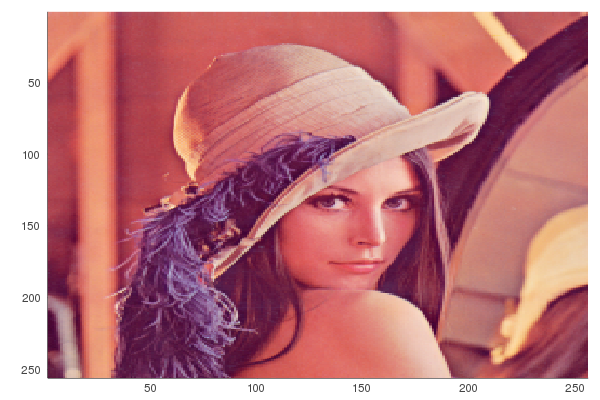

In [8]:
lena = testimage("lena_color_256")
plot(lena, fmt=:png)

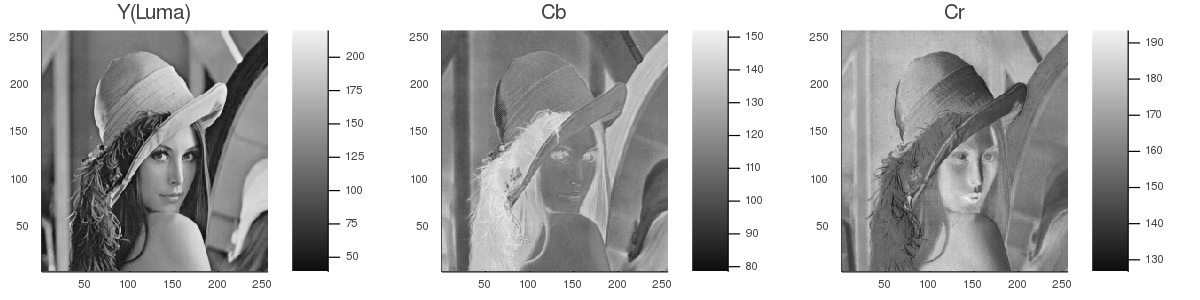

In [3]:
lena = YCbCr.(lena)
lena_arr = channelview(lena)

p_y = heatmap(reverse(lena_arr[1,:,:], dims=1), title="Y(Luma)", color=:grays)
p_cb = heatmap(reverse(lena_arr[2,:,:], dims=1), title="Cb", color=:grays)
p_cr = heatmap(reverse(lena_arr[3,:,:], dims=1), title="Cr", color=:grays)
plot(p_y, p_cb, p_cr, layout=(1, 3), size=(1200, 300), fmt=:png)

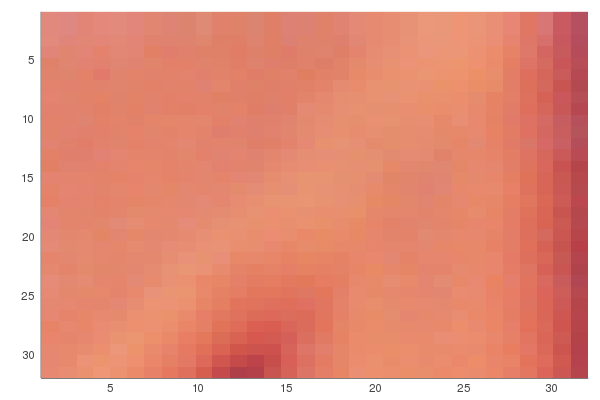

In [4]:
bs = 32 # block size
s = 1
e = s + bs - 1

plot(lena[s:e,s:e], fmt=:png)

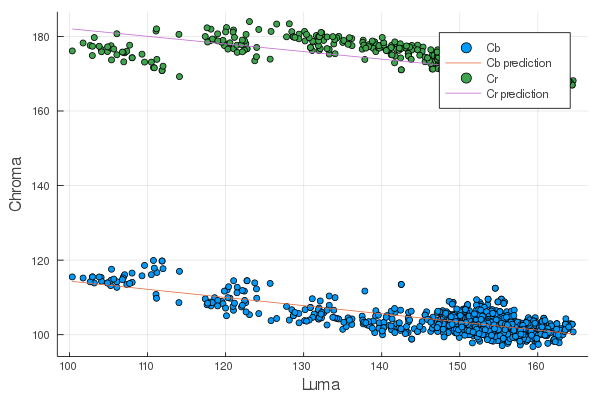

In [5]:
x_min = minimum(lena_arr[1,s:e,s:e])
x_max = maximum(lena_arr[1,s:e,s:e])

# Cb
x = vec(lena_arr[1,s:e,s:e])
y = vec(lena_arr[2,s:e,s:e])
scatter(x, y, label="Cb", xlabel="Luma", ylabel="Chroma")

cb_a = (bs*bs*sum(x.*y) - sum(x)*sum(y)) / (sum(bs*bs*(x.^2)) - sum(x)^2)
cb_b = (sum(y) - cb_a * sum(x)) / (bs*bs)
x = range(x_min, x_max, length=1000)
y = cb_a .* x .+ cb_b
plot!(x, y, label="Cb prediction")


x = vec(lena_arr[1,s:e,s:e])
y = vec(lena_arr[3,s:e,s:e])
scatter!(x, y, label="Cr")

cr_a = (bs*bs*sum(x.*y) - sum(x)*sum(y)) / (sum(bs*bs*(x.^2)) - sum(x)^2)
cr_b = (sum(y) - cr_a * sum(x)) / (bs*bs)
x = range(x_min, x_max, length=1000)
y = cr_a .* x .+ cr_b
plot!(x, y, label="Cr prediction", fmt=:png)

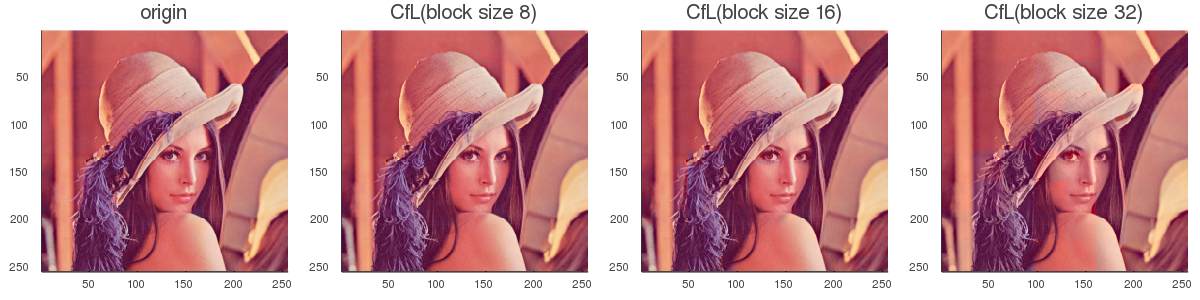

In [6]:
function cfl(img_arr, bs=8)
    nc, h, w = size(img_arr)
    img_arr_est = zeros((nc, h, w))
    
    for i in 1:Int(h/bs)
        si = (i-1)*bs + 1
        ei = i*bs
        for j in 1:Int(w/bs)
            sj = (j-1)*bs + 1
            ej = j*bs
            img_arr_tmp = img_arr[:, si:ei, sj:ej]

            # Cb
            x = vec(img_arr_tmp[1, :, :])
            y = vec(img_arr_tmp[2, :, :])
            cb_a = (bs*bs*sum(x.*y) - sum(x)*sum(y)) / (sum(bs*bs*(x.^2)) - sum(x)^2)
            cb_b = (sum(y) - cb_a * sum(x)) / (bs*bs)

            # Cr
            x = vec(img_arr_tmp[1, :, :])
            y = vec(img_arr_tmp[3, :, :])
            cr_a = (bs*bs*sum(x.*y) - sum(x)*sum(y)) / (sum(bs*bs*(x.^2)) - sum(x)^2)
            cr_b = (sum(y) - cr_a * sum(x)) / (bs*bs)

            x = img_arr_tmp[1, :, :]
            cb_est = cb_a .* x .+ cb_b
            cr_est = cr_a .* x .+ cr_b
            img_arr_est_tmp = zeros((3, bs, bs))
            img_arr_est_tmp[1,:,:] .= x
            img_arr_est_tmp[2,:,:] .= cb_est
            img_arr_est_tmp[3,:,:] .= cr_est

            img_arr_est[:, si:ei, sj:ej] .= img_arr_est_tmp
        end
    end
    img_arr_est
end

p_org = plot(colorview(YCbCr, lena_arr), title="origin")
p8 = plot(colorview(YCbCr, cfl(lena_arr, 8)), title="CfL(block size 8)")
p16 = plot(colorview(YCbCr, cfl(lena_arr, 16)), title="CfL(block size 16)")
p32 = plot(colorview(YCbCr, cfl(lena_arr, 32)), title="CfL(block size 32)")
plot(p_org, p8, p16, p32, layout = (1, 4), size = (1200, 300), fmt=:png)